✅ Data Loaded Successfully.
      video_id trending_date  \
0  n1WpP7iowLc      17.14.11   
1  0dBIkQ4Mz1M      17.14.11   
2  5qpjK5DgCt4      17.14.11   
3  d380meD0W0M      17.14.11   
4  2Vv-BfVoq4g      17.14.11   

                                               title channel_title  \
0         Eminem - Walk On Water (Audio) ft. Beyoncé    EminemVEVO   
1                      PLUSH - Bad Unboxing Fan Mail     iDubbbzTV   
2  Racist Superman | Rudy Mancuso, King Bach & Le...  Rudy Mancuso   
3                           I Dare You: GOING BALD!?      nigahiga   
4        Ed Sheeran - Perfect (Official Music Video)    Ed Sheeran   

   category_id               publish_time  \
0           10  2017-11-10 17:00:03+00:00   
1           23  2017-11-13 17:00:00+00:00   
2           23  2017-11-12 19:05:24+00:00   
3           24  2017-11-12 18:01:41+00:00   
4           10  2017-11-09 11:04:14+00:00   

                                                tags     views     likes  \
0  Eminem|"

a:\Youtube-TrendAnalysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:29:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 XGBoost Classifier Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     35775
           1       0.68      0.03      0.06       583

    accuracy                           0.98     36358
   macro avg       0.83      0.52      0.53     36358
weighted avg       0.98      0.98      0.98     36358

ROC-AUC Score: 0.9373463122982526


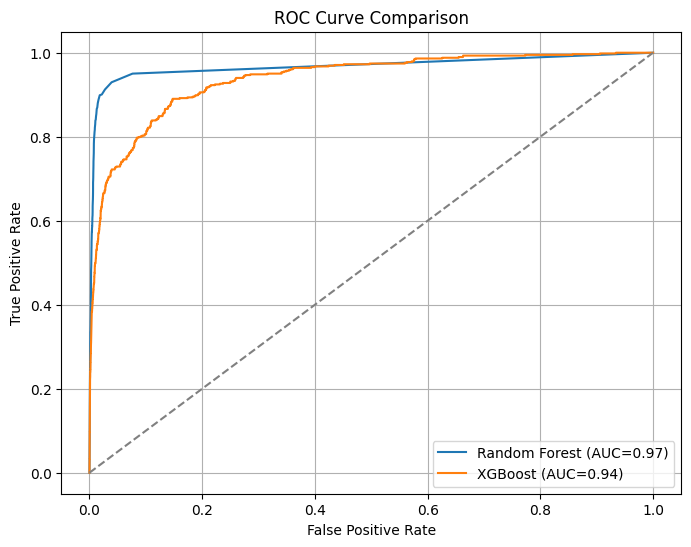


✅ Best model saved at '../models/recommendation_model.pkl' successfully.

📈 Best Hours to Upload for Trending Probability:
hour
5     0.061162
4     0.042289
23    0.018987
0     0.017680
9     0.017399
13    0.016331
8     0.015968
14    0.015618
3     0.015284
2     0.014035
1     0.013857
11    0.013571
16    0.013472
12    0.013401
7     0.013366
21    0.012641
20    0.009422
22    0.008791
17    0.007749
10    0.007700
15    0.006093
18    0.005206
19    0.002136
6     0.000000
Name: predicted, dtype: float64


C:\Users\hiite\AppData\Local\Temp\ipykernel_11760\558645879.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=best_hours.index, y=best_hours.values, palette="viridis")


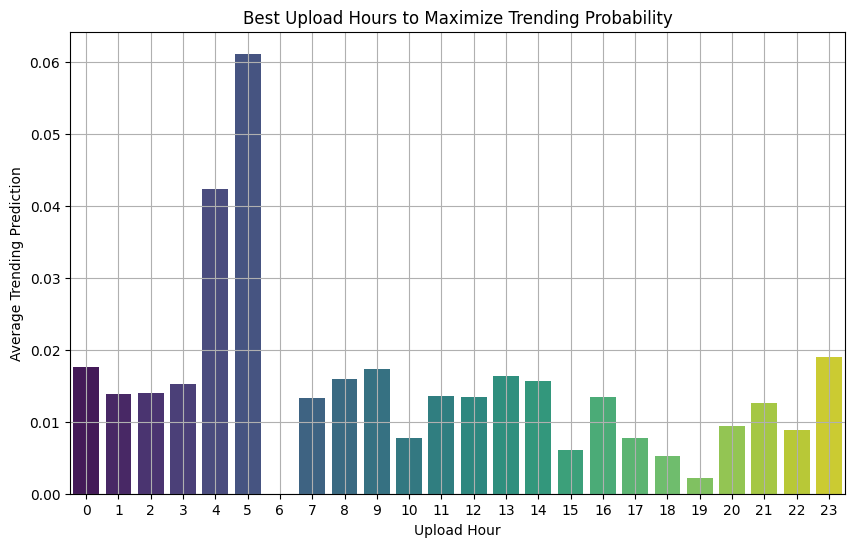


✅ Sample predict_proba output: [[1. 0.]]


In [2]:
# recommendation_system_fixed.py

# 1. Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# 2. Load Data
data = pd.read_csv('../data/processed_data.csv')
print("✅ Data Loaded Successfully.")
print(data.head())

# --- Fix Normalized Data ---
data['views'] = data['views'] * 1_000_000
data['likes'] = data['likes'] * 100_000
data['dislikes'] = data['dislikes'] * 10_000
data['comment_count'] = data['comment_count'] * 10_000
print("✅ De-normalized views, likes, dislikes, and comment_count.")

# 3. Feature Engineering
data['title_length'] = data['title'].apply(lambda x: len(str(x)))
data['num_tags'] = data['tags'].apply(lambda x: len(str(x).split('|')) if pd.notnull(x) else 0)
data['upload_hour'] = pd.to_datetime(data['publish_time']).dt.hour

# New Feature - Video Length
if 'video_length' not in data.columns:
    np.random.seed(42)
    data['video_length'] = np.random.uniform(1, 20, size=len(data))

print("✅ Features Created: title_length, num_tags, upload_hour, video_length")

# 4. Create Target Variable
if 'is_trending' not in data.columns:
    threshold = 50000  # Set realistic threshold
    data['is_trending'] = data['views'].apply(lambda x: 1 if x > threshold else 0)
    print(f"✅ Created 'is_trending' based on views > {threshold}")

# 5. Define Features and Target
features = ['title_length', 'num_tags', 'upload_hour', 'video_length']
X = data[features]
y = data['is_trending']

# 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("\n🎯 Checking y_train distribution:")
print(y_train.value_counts())

# 7. Baseline Model - Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Predictions
rf_preds = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
rf_auc = roc_auc_score(y_test, rf_probs)
print("\n📊 Random Forest Classifier Report")
print(classification_report(y_test, rf_preds))
print("ROC-AUC Score:", rf_auc)

# 8. Advanced Model - XGBoost
if len(y_train.unique()) >= 2:
    print("✅ Enough classes. Training XGBoost...")

    xgb_model = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    xgb_model.fit(X_train, y_train)

    # Predictions
    xgb_preds = xgb_model.predict(X_test)
    xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

    # Evaluation
    xgb_auc = roc_auc_score(y_test, xgb_probs)
    print("\n📊 XGBoost Classifier Report")
    print(classification_report(y_test, xgb_preds))
    print("ROC-AUC Score:", xgb_auc)
else:
    print("❌ XGBoost not trained. Only one class in y_train.")
    xgb_model, xgb_auc = None, 0

# 9. Plot ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={rf_auc:.2f})')

# Plot XGBoost ROC curve if trained
if xgb_model is not None:
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)
    plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={xgb_auc:.2f})')

plt.plot([0,1], [0,1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()

# 10. Save the Best Model
os.makedirs('../models', exist_ok=True)

best_model = xgb_model if (xgb_model is not None and xgb_auc > rf_auc) else rf_model
with open('../models/recommendation_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("\n✅ Best model saved at '../models/recommendation_model.pkl' successfully.")

# 11. Optimization Suggestions (Best Upload Hour)
upload_hour_performance = pd.DataFrame({
    'hour': X_test['upload_hour'],
    'actual': y_test,
    'predicted': xgb_preds if (xgb_model is not None and xgb_auc > rf_auc) else rf_preds
})
best_hours = upload_hour_performance.groupby('hour')['predicted'].mean().sort_values(ascending=False)

print("\n📈 Best Hours to Upload for Trending Probability:")
print(best_hours)

# Visualize
plt.figure(figsize=(10,6))
sns.barplot(x=best_hours.index, y=best_hours.values, palette="viridis")
plt.title('Best Upload Hours to Maximize Trending Probability')
plt.xlabel('Upload Hour')
plt.ylabel('Average Trending Prediction')
plt.xticks(range(0,24))
plt.grid()
plt.show()

# 12. Test predict_proba with sample input
sample_input = pd.DataFrame({
    'title_length': [60],
    'num_tags': [10],
    'upload_hour': [17],
    'video_length': [12.5]
})

with open('../models/recommendation_model.pkl', 'rb') as f:
    model = pickle.load(f)

sample_probs = model.predict_proba(sample_input)
print("\n✅ Sample predict_proba output:", sample_probs)
